In [1]:
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from numpy import mean

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)


#%%

In [2]:
#% ## Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
#features_list = ['poi','salary'] # You will need to use more features

############# Task 1: Select what features you'll use.############

target_label = 'poi'

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
    
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
    
### 1.1.0 Explore csv file 
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

### 1.1.1 Dataset Exploration
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))


###1.1.2 Feature Exploration
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

### Print results of completeness analysis
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_values[feature]))

#%%


# Exploratory Data Analysis #
Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128
Each person has 21 features available
Number of Missing Values for Each Feature:
salary: 51
to_messages: 60
deferral_payments: 107
total_payments: 21
loan_advances: 142
bonus: 64
email_address: 35
restricted_stock_deferred: 128
deferred_income: 97
total_stock_value: 20
expenses: 51
from_poi_to_this_person: 60
exercised_stock_options: 44
from_messages: 60
other: 53
from_this_person_to_poi: 60
poi: 0
long_term_incentive: 80
shared_receipt_with_poi: 60
restricted_stock: 36
director_fees: 129


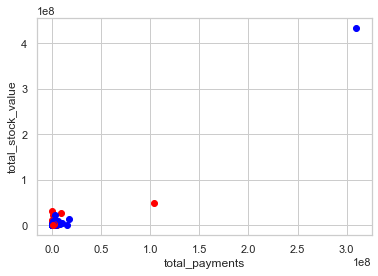

None


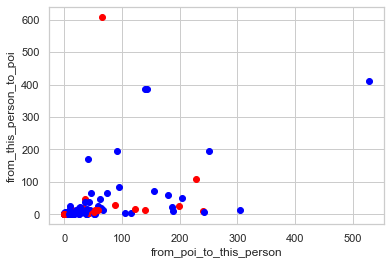

None


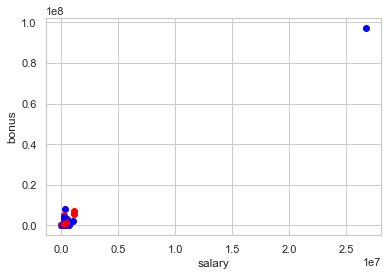

None


In [3]:
################# Task 2: Remove outliers #####################

def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

# 2.1 Visualise outliers
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))
#Remove outlier TOTAL line in pickle file.
data_dict.pop( 'TOTAL', 0 )


# 2.2 Function to remove outliers
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E','FREVERT MARK A','LAVARATO JOHN J',"SKILLING JEFFREY K","LAY KENNETH L"]
remove_outlier(data_dict, outliers)



#%%


In [4]:
import matplotlib.pyplot
def showData(data_set, first_feature, second_feature):
    data = featureFormat(data_set, [first_feature, second_feature, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        matplotlib.pyplot.scatter(x, y, color=color)

    matplotlib.pyplot.xlabel(first_feature)
    matplotlib.pyplot.ylabel(second_feature)
    matplotlib.pyplot.show()

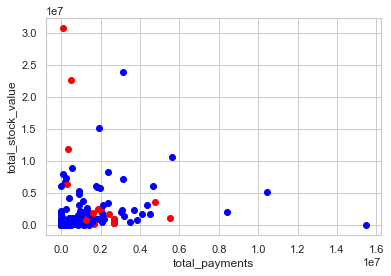

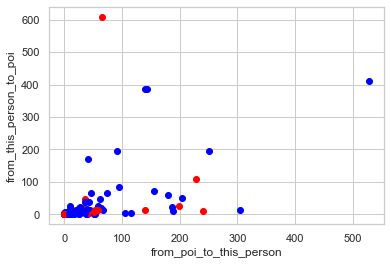

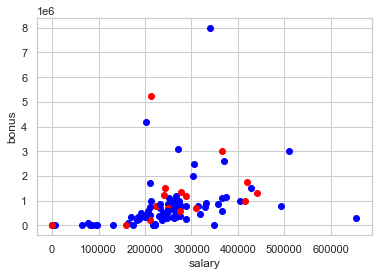

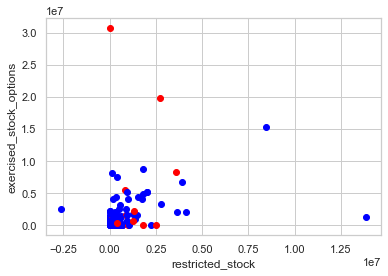

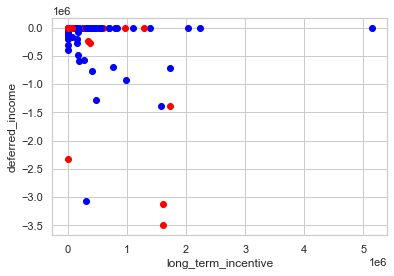

In [5]:
# Visualize data to identify outliers
# data_dict.T.to_dict
# data_dict.pop('LAY KENNETH L',0)
showData(data_dict, 'total_payments','total_stock_value')
showData(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi')
showData(data_dict, 'salary', 'bonus')
showData(data_dict, 'restricted_stock', 'exercised_stock_options')
showData(data_dict, 'long_term_incentive', 'deferred_income')

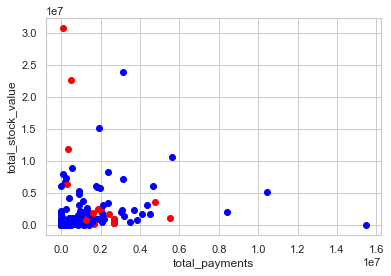

None


In [6]:
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))

In [7]:
### 1.1.0 Explore csv file 
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

### 1.1.1 Dataset Exploration
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))


###1.1.2 Feature Exploration
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

### Print results of completeness analysis
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_values[feature]))

#%%

# Exploratory Data Analysis #
Total number of data points: 140
Number of Persons of Interest: 16
Number of people without Person of Interest label: 124
Each person has 21 features available
Number of Missing Values for Each Feature:
salary: 49
to_messages: 57
deferral_payments: 104
total_payments: 20
loan_advances: 139
bonus: 62
email_address: 32
restricted_stock_deferred: 123
deferred_income: 94
total_stock_value: 18
expenses: 49
from_poi_to_this_person: 57
exercised_stock_options: 42
from_messages: 57
other: 52
from_this_person_to_poi: 57
poi: 0
long_term_incentive: 78
shared_receipt_with_poi: 57
restricted_stock: 34
director_fees: 124


In [8]:
df=pd.DataFrame.from_dict(data_dict, orient = 'index')
# data=df.T
df.replace('nan',np.nan)
df.replace(to_replace='NaN', value=np.nan, inplace=True)
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788.0,807.0,NaN,1061827.0,NaN,600000.0,mark.metts@enron.com,NaN,NaN,585062.0,...,38.0,NaN,29.0,1740.0,1.0,False,NaN,702.0,585062.0,NaN
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,NaN,1200000.0,NaN,NaN,-1386055.0,10623258.0,...,NaN,6680544.0,NaN,2660303.0,NaN,False,1586055.0,NaN,3942714.0,NaN
ELLIOTT STEVEN,170941.0,NaN,NaN,211725.0,NaN,350000.0,steven.elliott@enron.com,NaN,-400729.0,6678735.0,...,NaN,4890344.0,NaN,12961.0,NaN,False,NaN,NaN,1788391.0,NaN
CORDES WILLIAM R,NaN,764.0,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185.0,...,10.0,651850.0,12.0,NaN,0.0,False,NaN,58.0,386335.0,NaN
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,NaN,1500000.0,kevin.hannon@enron.com,NaN,-3117011.0,6391065.0,...,32.0,5538001.0,32.0,11350.0,21.0,True,1617011.0,1035.0,853064.0,NaN


In [12]:
df.dtypes

salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
loan_advances                float64
bonus                        float64
email_address                 object
restricted_stock_deferred    float64
deferred_income              float64
total_stock_value            float64
expenses                     float64
from_poi_to_this_person      float64
exercised_stock_options      float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                             bool
long_term_incentive          float64
shared_receipt_with_poi      float64
restricted_stock             float64
director_fees                float64
dtype: object

In [ ]:
# for col in ['from_messages','from_poi_to_this_person','from_this_person_to_poi',
#     'shared_receipt_with_poi',
#     'to_messages',
#     'bonus',
#     'deferral_payments',
#     'deferred_income',
#     'director_fees',
#     'exercised_stock_options',
#     'expenses',
#     'long_term_incentive',
#     'other',
#     'restricted_stock',
#     'salary',
#     'total_payments',
#     'total_stock_value']:
#     df[col] = df[col].astype('int')

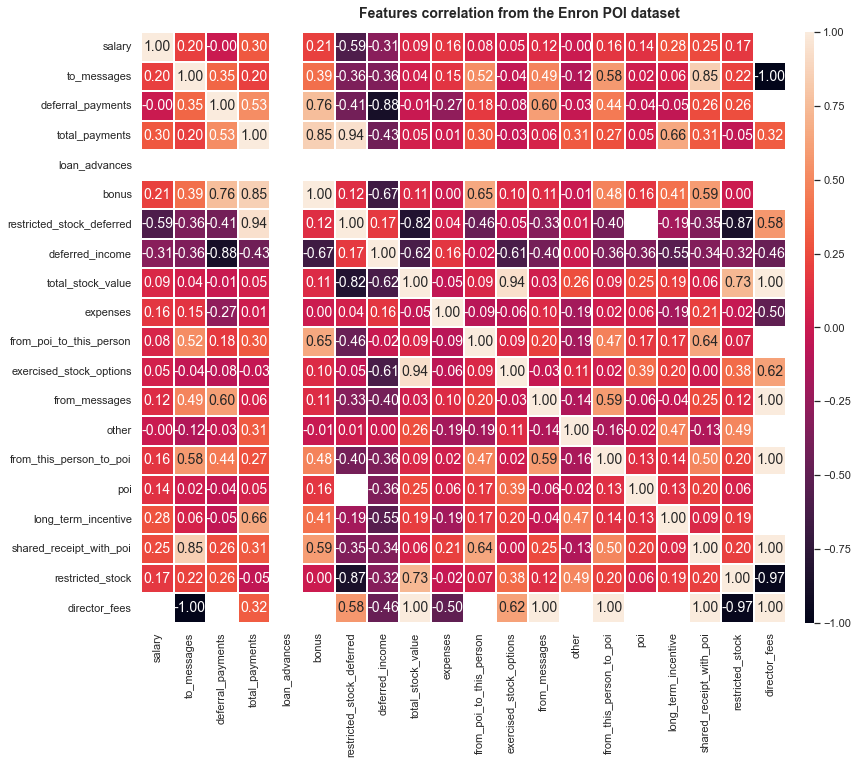

In [14]:
# data_without_na=data.dropna()

# f, ax = plt.subplots(figsize=(10, 8))
# corr = df.corr()
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
#             cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
# # sns.heatmap(corr)
# corr

import seaborn as sns
dfp=df.drop(['poi'], axis=1)
## Calculating the correlation among features by Pearson method
correlationDataframe = df.corr()

# Drawing a heatmap with the numeric values in each cell
fig1, ax = plt.subplots(figsize=(14,10))
fig1.subplots_adjust(top=.945)
plt.suptitle('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"vertical", 'pad':0.025, 'aspect':70}
sns.heatmap(correlationDataframe, annot=True, fmt='.2f', linewidths=.3, ax=ax, cbar_kws=cbar_kws);

In [15]:
df['poi'].head()

METTS MARK          False
BAXTER JOHN C       False
ELLIOTT STEVEN      False
CORDES WILLIAM R    False
HANNON KEVIN P       True
Name: poi, dtype: bool

<AxesSubplot:>

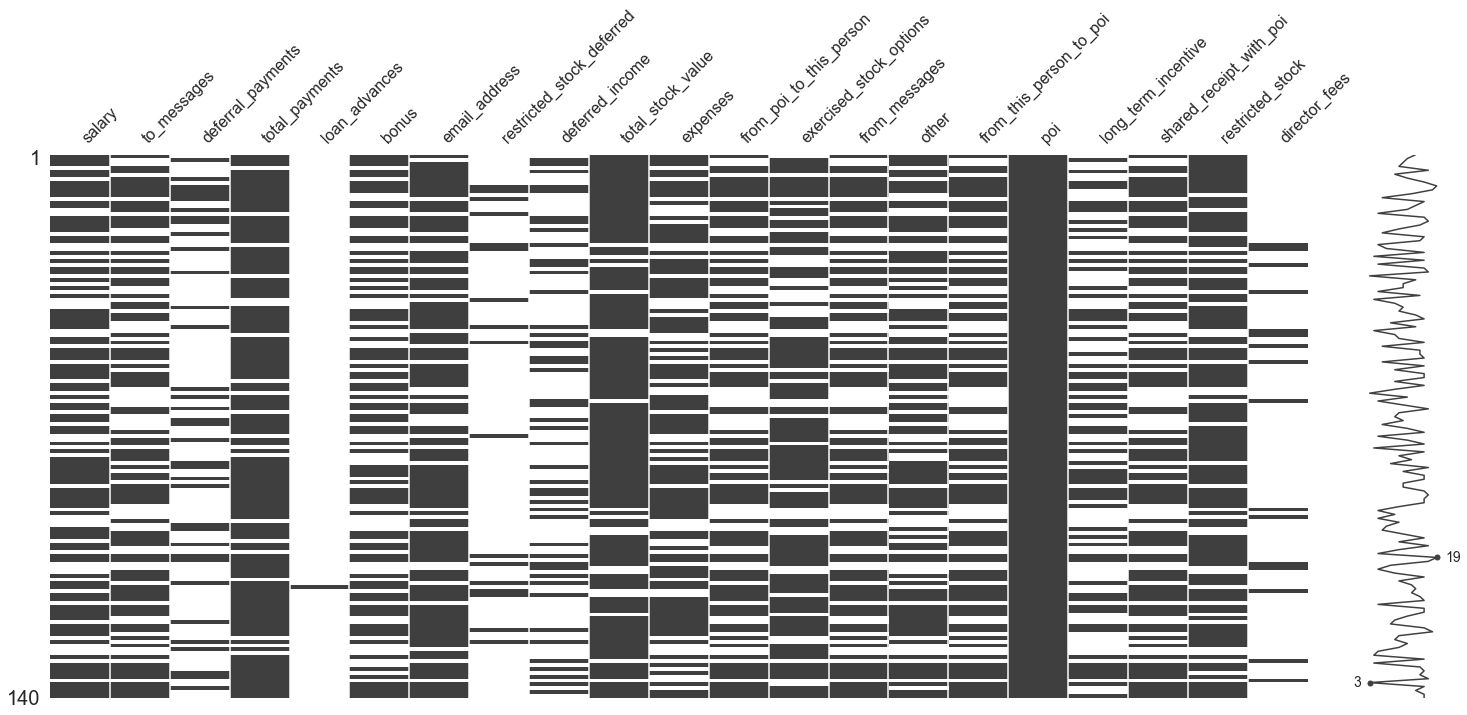

In [16]:
import missingno as msno  # # pip install missingno

# Plot correlation heatmap of missingness
msno.matrix(df)

<AxesSubplot:>

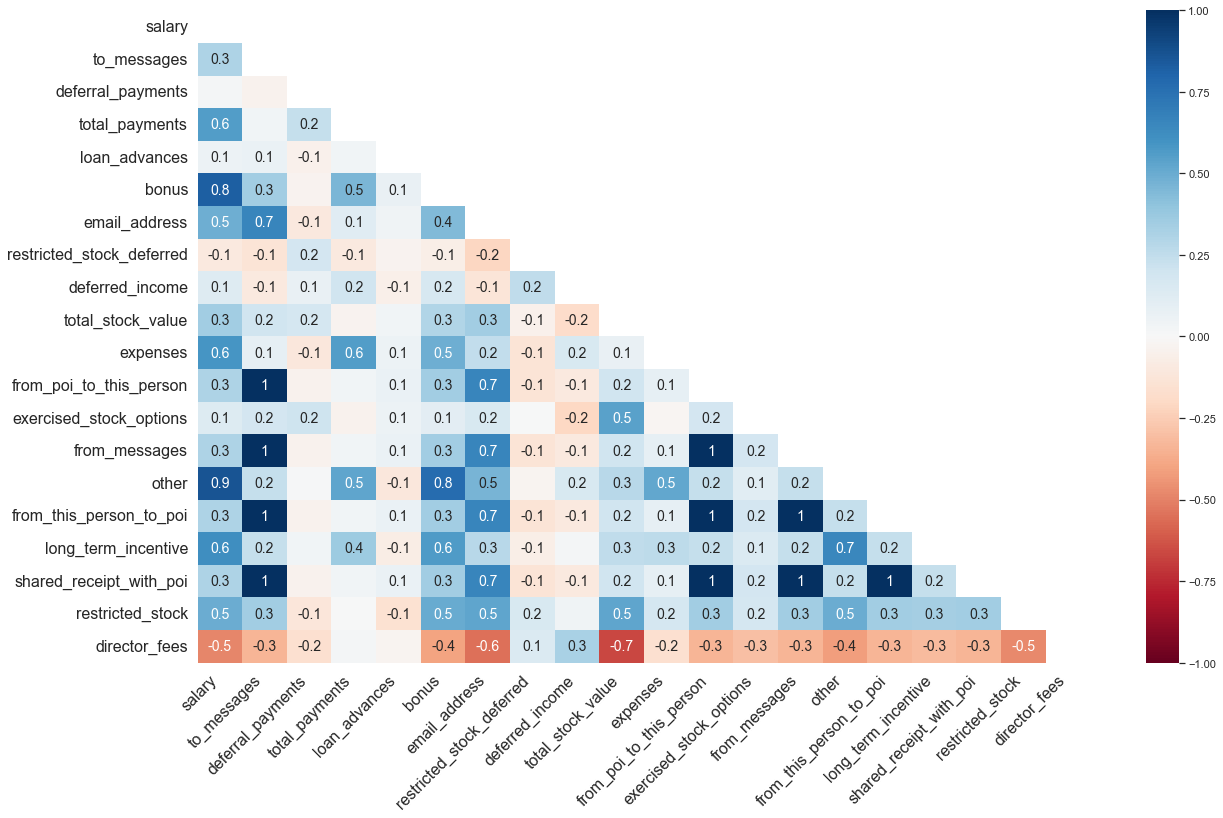

In [17]:
msno.heatmap(df)

In [18]:
df.dtypes

salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
loan_advances                float64
bonus                        float64
email_address                 object
restricted_stock_deferred    float64
deferred_income              float64
total_stock_value            float64
expenses                     float64
from_poi_to_this_person      float64
exercised_stock_options      float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                             bool
long_term_incentive          float64
shared_receipt_with_poi      float64
restricted_stock             float64
director_fees                float64
dtype: object

In [19]:
df_min = df[['from_messages',
      'from_poi_to_this_person',
      'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    'bonus',
    'deferral_payments',
    'deferred_income',
    'exercised_stock_options',
    'expenses',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'salary',
    'total_payments',
    'total_stock_value',
           ]]

In [20]:
df.index

Index(['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R',
       'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G',
       'MCMAHON JEFFREY', 'HAEDICKE MARK E', 'PIPER GREGORY F',
       ...
       'SAVAGE FRANK', 'IZZO LAWRENCE L', 'TILNEY ELIZABETH A',
       'MARTIN AMANDA K', 'BUY RICHARD B', 'GRAMM WENDY L', 'CAUSEY RICHARD A',
       'TAYLOR MITCHELL S', 'DONAHUE JR JEFFREY M', 'GLISAN JR BEN F'],
      dtype='object', length=140)

In [21]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=0)
# df_no_na = df.dropna()
imp_mean.fit(df_min)
x = imp_mean.transform(df_min)


In [22]:
df.poi

METTS MARK              False
BAXTER JOHN C           False
ELLIOTT STEVEN          False
CORDES WILLIAM R        False
HANNON KEVIN P           True
                        ...  
GRAMM WENDY L           False
CAUSEY RICHARD A         True
TAYLOR MITCHELL S       False
DONAHUE JR JEFFREY M    False
GLISAN JR BEN F          True
Name: poi, Length: 140, dtype: bool

In [23]:
len(x)

140

In [24]:
len(x[0])

17

In [25]:
df_new = pd.DataFrame(x, index = df.index,
                      columns =['from_messages',
      'from_poi_to_this_person',
      'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'salary',
    'total_payments',
    'total_stock_value',
           ])
df_new.head()

,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,total_payments,total_stock_value
METTS MARK,29.000000,38.000000,1.000000,702.000000,807.000000,6.000000e+05,6.401800e+05,-3.410231e+05,84112.316976,2.219041e+05,94299.000000,2.183082e+05,1.740000e+03,585062.0,365788.000000,1.061827e+06,585062.0
BAXTER JOHN C,738.974534,0.010231,22.512464,1110.851634,2191.506125,1.200000e+06,1.295738e+06,-1.386055e+06,20119.888921,6.680544e+06,11200.000000,1.586055e+06,2.660303e+06,3942714.0,267102.000000,5.634343e+06,10623258.0
ELLIOTT STEVEN,749.265569,87.116032,68.405437,1141.741251,2012.728658,3.500000e+05,5.802994e+05,-4.007290e+05,82912.563781,4.890344e+06,78552.000000,-5.259623e+05,1.296100e+04,1788391.0,170941.000000,2.117250e+05,6678735.0
CORDES WILLIAM R,12.000000,10.000000,0.000000,58.000000,764.000000,1.105180e+06,6.587563e+05,-4.272782e+05,88021.178857,6.518500e+05,55384.154677,5.078614e+05,2.059398e+05,386335.0,257523.620161,2.100119e+06,1038185.0
HANNON KEVIN P,32.000000,32.000000,21.000000,1035.000000,1045.000000,1.500000e+06,4.117421e+05,-3.117011e+06,428616.369151,5.538001e+06,34039.000000,1.617011e+06,1.135000e+04,853064.0,243293.000000,2.886820e+05,6391065.0


array([[<AxesSubplot:title={'center':'from_messages'}>,
        <AxesSubplot:title={'center':'from_poi_to_this_person'}>,
        <AxesSubplot:title={'center':'from_this_person_to_poi'}>,
        <AxesSubplot:title={'center':'shared_receipt_with_poi'}>],
       [<AxesSubplot:title={'center':'to_messages'}>,
        <AxesSubplot:title={'center':'bonus'}>,
        <AxesSubplot:title={'center':'deferral_payments'}>,
        <AxesSubplot:title={'center':'deferred_income'}>],
       [<AxesSubplot:title={'center':'director_fees'}>,
        <AxesSubplot:title={'center':'exercised_stock_options'}>,
        <AxesSubplot:title={'center':'expenses'}>,
        <AxesSubplot:title={'center':'long_term_incentive'}>],
       [<AxesSubplot:title={'center':'other'}>,
        <AxesSubplot:title={'center':'restricted_stock'}>,
        <AxesSubplot:title={'center':'salary'}>,
        <AxesSubplot:title={'center':'total_payments'}>],
       [<AxesSubplot:title={'center':'total_stock_value'}>,
        <AxesS

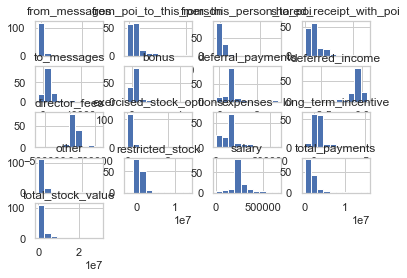

In [26]:
df_new.hist()

<AxesSubplot:>

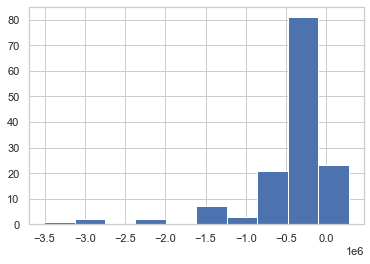

In [27]:
df_new['deferred_income'].hist()

In [28]:
print(len(pd.concat([df_new, df.poi],axis=1)))
df_good = pd.concat([df_new, df.poi],axis=1)
df_good.head(10)

140


,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,total_payments,total_stock_value,poi
METTS MARK,29.000000,38.000000,1.000000,702.000000,807.000000,6.000000e+05,6.401800e+05,-3.410231e+05,84112.316976,2.219041e+05,94299.000000,2.183082e+05,1.740000e+03,585062.0,365788.000000,1.061827e+06,585062.0,False
BAXTER JOHN C,738.974534,0.010231,22.512464,1110.851634,2191.506125,1.200000e+06,1.295738e+06,-1.386055e+06,20119.888921,6.680544e+06,11200.000000,1.586055e+06,2.660303e+06,3942714.0,267102.000000,5.634343e+06,10623258.0,False
ELLIOTT STEVEN,749.265569,87.116032,68.405437,1141.741251,2012.728658,3.500000e+05,5.802994e+05,-4.007290e+05,82912.563781,4.890344e+06,78552.000000,-5.259623e+05,1.296100e+04,1788391.0,170941.000000,2.117250e+05,6678735.0,False
CORDES WILLIAM R,12.000000,10.000000,0.000000,58.000000,764.000000,1.105180e+06,6.587563e+05,-4.272782e+05,88021.178857,6.518500e+05,55384.154677,5.078614e+05,2.059398e+05,386335.0,257523.620161,2.100119e+06,1038185.0,False
HANNON KEVIN P,32.000000,32.000000,21.000000,1035.000000,1045.000000,1.500000e+06,4.117421e+05,-3.117011e+06,428616.369151,5.538001e+06,34039.000000,1.617011e+06,1.135000e+04,853064.0,243293.000000,2.886820e+05,6391065.0,True
MORDAUNT KRISTINA M,435.627450,43.773461,7.813687,776.235143,1493.738213,3.250000e+05,6.034942e+05,-3.455172e+05,117334.947096,2.175428e+05,35018.000000,1.375308e+05,1.411000e+03,208510.0,267093.000000,6.285220e+05,208510.0,False
MEYER ROCKFORD G,28.000000,0.000000,0.000000,22.000000,232.000000,3.907345e+05,1.848227e+06,-6.503719e+05,242774.692168,4.934890e+05,53373.280751,-2.474336e+05,1.956581e+05,462384.0,240316.580390,1.848227e+06,955873.0,False
MCMAHON JEFFREY,48.000000,58.000000,26.000000,2228.000000,2355.000000,2.600000e+06,8.047686e+05,-4.460246e+05,48821.676543,1.104054e+06,137108.000000,6.948620e+05,2.973530e+05,558801.0,370448.000000,4.099771e+06,1662855.0,False
HAEDICKE MARK E,1941.000000,180.000000,61.000000,1847.000000,4009.000000,1.150000e+06,2.157527e+06,-9.344840e+05,286056.957183,6.087500e+05,76169.000000,9.833460e+05,5.238200e+04,524169.0,374125.000000,3.859065e+06,803094.0,False
PIPER GREGORY F,222.000000,61.000000,48.000000,742.000000,1238.000000,4.000000e+05,1.130036e+06,-3.333300e+04,129102.776825,8.802900e+05,43057.000000,7.340903e+04,7.780000e+02,409554.0,197091.000000,1.737629e+06,880290.0,False


In [ ]:
!pip install imblearn

In [29]:
X = df_good.loc[:, df_good.columns != 'poi']
y = df_good.loc[:, df_good.columns == 'poi']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['poi'])
# we can Check the numbers of our data
print("length of the oversampled ",len(os_data_X))
print("Number de non poi of the oversampled ",len(os_data_y[os_data_y['poi']==0]))
print("Number poi of the oversampled ",len(os_data_y[os_data_y['poi']==1]))
print("Proportion of non poi of the oversampled ",len(os_data_y[os_data_y['poi']==0])/len(os_data_X))
print("Proportion of poi of the oversampled ",len(os_data_y[os_data_y['poi']==1])/len(os_data_X))

length of the oversampled  170
Number de non poi of the oversampled  85
Number poi of the oversampled  85
Proportion of non poi of the oversampled  0.5
Proportion of poi of the oversampled  0.5


In [33]:
os_data_X.describe()

,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,total_payments,total_stock_value
count,170.000000,170.000000,170.000000,170.000000,170.000000,1.700000e+02,1.700000e+02,1.700000e+02,170.000000,1.700000e+02,170.000000,1.700000e+02,1.700000e+02,1.700000e+02,170.000000,1.700000e+02,1.700000e+02
mean,524.804852,67.908550,39.998475,1230.510848,1939.105628,9.067212e+05,6.258714e+05,-6.477698e+05,99709.440667,2.284846e+06,61937.588188,5.691700e+05,2.784871e+05,1.087190e+06,267926.463999,1.761661e+06,3.169815e+06
std,1377.200419,71.710633,80.462133,968.882238,1722.447597,1.306300e+06,4.001231e+05,7.409370e+05,134234.321736,4.798595e+06,36206.739714,6.370335e+05,4.028893e+05,1.386130e+06,70563.514088,1.700775e+06,5.214412e+06
min,-694.788185,-16.746134,-50.291727,-48.478478,-1235.478616,-1.017534e+06,-1.930436e+05,-3.504386e+06,-646598.652918,-1.754583e+05,148.000000,-9.050521e+05,-1.549028e+04,-2.604490e+06,6615.000000,1.480000e+02,4.730400e+04
25%,35.897035,24.639730,7.000000,617.549824,1068.771766,4.000000e+05,4.788776e+05,-7.129655e+05,31314.640689,2.225938e+05,39143.120258,2.276658e+05,4.877247e+04,3.250047e+05,230285.647401,8.575077e+05,6.700083e+05
50%,218.500000,51.559889,15.990397,1045.664082,1633.228071,7.803234e+05,6.081253e+05,-3.848932e+05,82891.256058,6.475556e+05,54326.913090,4.007084e+05,1.505570e+05,8.242549e+05,251444.777890,1.662047e+06,1.443352e+06
75%,494.821600,84.553174,44.690955,1501.307283,2341.597345,1.111890e+06,6.668104e+05,-2.382269e+05,120120.425851,1.788413e+06,80357.273408,7.058909e+05,3.008775e+05,1.376999e+06,288129.195192,2.155587e+06,2.583747e+06
max,14368.000000,528.000000,720.043054,6429.393467,12754.000000,1.187216e+07,3.131860e+06,2.763559e+05,610378.087185,3.076606e+07,228763.000000,5.145434e+06,2.818454e+06,1.384707e+07,463907.372521,1.545629e+07,3.076606e+07


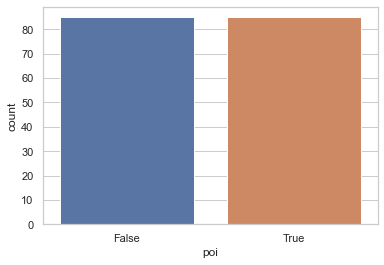

In [32]:
sns.countplot(x='poi',data=os_data_y)
plt.show()

In [36]:
#  len(os_data_y)

,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,total_payments,total_stock_value,poi
0,311.417382,52.334919,13.430709,502.718709,1280.287401,2.000000e+05,2.040750e+05,1.636151e+05,15922.112613,2.549361e+06,57727.000000,1.750000e+05,2630.000000,514847.0,236457.000000,8.758890e+05,3064208.0,False
1,63.000000,305.000000,14.000000,1902.000000,2572.000000,6.000000e+05,5.973899e+05,-4.628373e+05,122771.360624,1.550019e+06,3475.000000,5.564160e+05,473.000000,315068.0,250100.000000,1.410464e+06,1865087.0,False
2,125.000000,0.000000,0.000000,23.000000,1088.000000,5.000000e+05,5.945751e+05,-3.761795e+05,116750.093081,8.254640e+05,600.000000,3.048050e+05,1215.000000,189041.0,248017.000000,1.054637e+06,1014505.0,False
3,1073.000000,44.000000,15.000000,1074.000000,2350.000000,8.365185e+05,3.131860e+06,-1.262154e+06,382174.600969,5.210569e+06,50837.521324,-9.050521e+05,507330.762704,2046079.0,254793.614216,3.131860e+06,7256648.0,False
4,355.815198,18.745933,-7.450923,697.987349,1657.330970,-1.060822e+05,5.643480e+05,-2.881020e+05,110013.573091,8.862310e+05,54721.764509,2.650436e+05,48336.822188,208809.0,231686.417096,5.643480e+05,1095040.0,False
5,1325.459682,57.612034,107.137743,2013.870120,3403.811040,1.300000e+06,6.069661e+05,-1.386055e+06,105810.013195,2.314778e+05,55921.000000,1.736055e+06,277464.000000,1794412.0,440698.000000,2.424083e+06,1794412.0,True
6,1053.000000,156.000000,71.000000,2333.000000,3523.000000,9.000000e+05,6.495840e+05,-6.948620e+05,99941.228141,2.542813e+06,53588.660679,7.698620e+05,400572.000000,901657.0,330546.000000,2.355702e+06,3444470.0,False
7,38.000000,37.000000,13.000000,2565.000000,2647.000000,7.000000e+05,6.466132e+05,-3.701634e+05,71667.638650,5.585913e+04,53806.936969,4.764510e+05,111122.000000,698920.0,257486.000000,1.545059e+06,698920.0,False
8,74.000000,115.000000,4.000000,552.000000,714.000000,6.000000e+05,6.198958e+05,-3.540137e+05,106064.405596,1.737800e+04,41626.000000,3.353490e+05,25553.000000,141833.0,206121.000000,1.208649e+06,159211.0,False
9,25.000000,39.000000,18.000000,583.000000,613.000000,1.104629e+06,6.492828e+05,-4.666275e+05,99014.480461,1.426469e+06,56227.230733,4.910646e+05,207035.292263,405999.0,257372.043590,2.082531e+06,1832468.0,False


In [37]:
data_dict_new.columns

Index(['from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'shared_receipt_with_poi', 'to_messages', 'bonus', 'deferral_payments',
       'deferred_income', 'director_fees', 'exercised_stock_options',
       'expenses', 'long_term_incentive', 'other', 'restricted_stock',
       'salary', 'total_payments', 'total_stock_value', 'poi'],
      dtype='object')

In [51]:
my_dataset.to_dict('index')


{0: {'from_messages': 311.41738159611623,
  'from_poi_to_this_person': 52.3349185545827,
  'from_this_person_to_poi': 13.430709081886917,
  'shared_receipt_with_poi': 502.71870914133615,
  'to_messages': 1280.2874011364765,
  'bonus': 200000.0,
  'deferral_payments': 204075.0,
  'deferred_income': 163615.0803246688,
  'director_fees': 15922.112613281359,
  'exercised_stock_options': 2549361.0,
  'expenses': 57727.0,
  'long_term_incentive': 175000.0,
  'other': 2630.0,
  'restricted_stock': 514847.0,
  'salary': 236457.0,
  'total_payments': 875889.0,
  'total_stock_value': 3064208.0,
  'poi': False},
 1: {'from_messages': 63.0,
  'from_poi_to_this_person': 305.0,
  'from_this_person_to_poi': 14.0,
  'shared_receipt_with_poi': 1902.0,
  'to_messages': 2572.0,
  'bonus': 600000.0,
  'deferral_payments': 597389.8700599298,
  'deferred_income': -462837.2768274412,
  'director_fees': 122771.3606239731,
  'exercised_stock_options': 1550019.0,
  'expenses': 3475.0,
  'long_term_incentive': 5

In [55]:
my_dataset

{0: {'from_messages': 311.41738159611623,
  'from_poi_to_this_person': 52.3349185545827,
  'from_this_person_to_poi': 13.430709081886917,
  'shared_receipt_with_poi': 502.71870914133615,
  'to_messages': 1280.2874011364765,
  'bonus': 200000.0,
  'deferral_payments': 204075.0,
  'deferred_income': 163615.0803246688,
  'director_fees': 15922.112613281359,
  'exercised_stock_options': 2549361.0,
  'expenses': 57727.0,
  'long_term_incentive': 175000.0,
  'other': 2630.0,
  'restricted_stock': 514847.0,
  'salary': 236457.0,
  'total_payments': 875889.0,
  'total_stock_value': 3064208.0,
  'poi': False},
 1: {'from_messages': 63.0,
  'from_poi_to_this_person': 305.0,
  'from_this_person_to_poi': 14.0,
  'shared_receipt_with_poi': 1902.0,
  'to_messages': 2572.0,
  'bonus': 600000.0,
  'deferral_payments': 597389.8700599298,
  'deferred_income': -462837.2768274412,
  'director_fees': 122771.3606239731,
  'exercised_stock_options': 1550019.0,
  'expenses': 3475.0,
  'long_term_incentive': 5

In [53]:
# print(data_dict_new.columns)
# print("#"*15)
# i=data_dict_new.columns
# print(i)
# print("#"*15)
# c = i[0]
# i[0] = i[-1]
# i[-1] = i[c]
# print(i)
features_list = ['poi','from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'shared_receipt_with_poi', 'to_messages', 'bonus', 'deferral_payments',
       'deferred_income', 'director_fees', 'exercised_stock_options',
       'expenses', 'long_term_incentive', 'other', 'restricted_stock',
       'salary', 'total_payments', 'total_stock_value']

In [59]:
os_data_X['all_messages'] = os_data_X['from_messages']+os_data_X['to_messages']

os_data_X['incentive'] = os_data_X["restricted_stock"]/os_data_X["long_term_incentive"]
os_data_X['bonus_salary'] = os_data_X["bonus"]/os_data_X["salary"]
os_data_X['expenses_salary'] = os_data_X["expenses"]/os_data_X["salary"]
os_data_X['shared_ratio'] = os_data_X["shared_receipt_with_poi"]/os_data_X["all_messages"]
os_data_X['all_poi_ratio'] = ((os_data_X["shared_receipt_with_poi"]+
                            os_data_X["from_poi_to_this_person"]+
                            os_data_X["from_this_person_to_poi"])/
                              os_data_X["all_messages"])
os_data_X['fraction_from_poi'] = os_data_X["from_poi_to_this_person"]/os_data_X["to_messages"]
os_data_X['fraction_to_poi'] = os_data_X["fraction_from_poi"]/os_data_X["from_messages"]
#     data_point = my_dataset[name]
#     from_poi_to_this_person = data_point["from_poi_to_this_person"]
#     to_messages = data_point["to_messages"]
#     fraction_from_poi = compute_fractio(from_poi_to_this_person, to_messages)
#     data_point["fraction_from_poi"] = fraction_from_poi
#     from_this_person_to_poi = data_point["from_this_person_to_poi"]
#     from_messages = data_point["from_messages"]
#     fraction_to_poi = compute_fractio(from_this_person_to_poi, from_messages)
#     data_point["fraction_to_poi"] = fraction_to_poi


In [60]:
data_dict_new = pd.concat([os_data_X, os_data_y],axis=1)
data_dict_new.head(10)

,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,...,total_stock_value,all_messages,incentive,bonus_salary,expenses_salary,shared_ratio,all_poi_ratio,fraction_from_poi,fraction_to_poi,poi
0,311.417382,52.334919,13.430709,502.718709,1280.287401,2.000000e+05,2.040750e+05,1.636151e+05,15922.112613,2.549361e+06,...,3064208.0,1591.704783,2.941983,0.845820,0.244133,0.315837,0.357154,0.040877,0.000131,False
1,63.000000,305.000000,14.000000,1902.000000,2572.000000,6.000000e+05,5.973899e+05,-4.628373e+05,122771.360624,1.550019e+06,...,1865087.0,2635.000000,0.566245,2.399040,0.013894,0.721822,0.842884,0.118585,0.001882,False
2,125.000000,0.000000,0.000000,23.000000,1088.000000,5.000000e+05,5.945751e+05,-3.761795e+05,116750.093081,8.254640e+05,...,1014505.0,1213.000000,0.620203,2.015991,0.002419,0.018961,0.018961,0.000000,0.000000,False
3,1073.000000,44.000000,15.000000,1074.000000,2350.000000,8.365185e+05,3.131860e+06,-1.262154e+06,382174.600969,5.210569e+06,...,7256648.0,3423.000000,-2.260731,3.283122,0.199524,0.313760,0.330996,0.018723,0.000017,False
4,355.815198,18.745933,-7.450923,697.987349,1657.330970,-1.060822e+05,5.643480e+05,-2.881020e+05,110013.573091,8.862310e+05,...,1095040.0,2013.146168,0.787829,-0.457870,0.236189,0.346715,0.352325,0.011311,0.000032,False
5,1325.459682,57.612034,107.137743,2013.870120,3403.811040,1.300000e+06,6.069661e+05,-1.386055e+06,105810.013195,2.314778e+05,...,1794412.0,4729.270721,1.033615,2.949866,0.126892,0.425831,0.460667,0.016926,0.000013,True
6,1053.000000,156.000000,71.000000,2333.000000,3523.000000,9.000000e+05,6.495840e+05,-6.948620e+05,99941.228141,2.542813e+06,...,3444470.0,4576.000000,1.171193,2.722768,0.162122,0.509834,0.559441,0.044280,0.000042,False
7,38.000000,37.000000,13.000000,2565.000000,2647.000000,7.000000e+05,6.466132e+05,-3.701634e+05,71667.638650,5.585913e+04,...,698920.0,2685.000000,1.466929,2.718594,0.208970,0.955307,0.973929,0.013978,0.000368,False
8,74.000000,115.000000,4.000000,552.000000,714.000000,6.000000e+05,6.198958e+05,-3.540137e+05,106064.405596,1.737800e+04,...,159211.0,788.000000,0.422941,2.910912,0.201949,0.700508,0.851523,0.161064,0.002177,False
9,25.000000,39.000000,18.000000,583.000000,613.000000,1.104629e+06,6.492828e+05,-4.666275e+05,99014.480461,1.426469e+06,...,1832468.0,638.000000,0.826773,4.291955,0.218467,0.913793,1.003135,0.063622,0.002545,False


In [61]:
################ Task 3: Create new feature(s) ####################

# 3.1 create new copies of dataset for grading


# ## 3.2 add new features to dataset
# def compute_fraction(poi_messages, all_messages):
#     """ return fraction of messages from/to that person to/from POI"""    
#     if poi_messages == 0 or all_messages == 0:
#         return 0.

#     fraction = poi_messages / all_messages
#     return fraction

# def compute_fractio(poi_messages, all_messages):
#     """ return fraction of messages from/to that person to/from POI"""    
#     if poi_messages == 0 or all_messages == 0:
#         return 0.
#     fraction = poi_messages / all_messages
#     return np.log(fraction)


# for name in my_dataset:
#     data_point = my_dataset[name]
#     from_poi_to_this_person = data_point["from_poi_to_this_person"]
#     to_messages = data_point["to_messages"]
#     fraction_from_poi = compute_fractio(from_poi_to_this_person, to_messages)
#     data_point["fraction_from_poi"] = fraction_from_poi
#     from_this_person_to_poi = data_point["from_this_person_to_poi"]
#     from_messages = data_point["from_messages"]
#     fraction_to_poi = compute_fractio(from_this_person_to_poi, from_messages)
#     data_point["fraction_to_poi"] = fraction_to_poi
    
# # for name in my_dataset:
# #     data_point = my_dataset[name]
#     salary = data_point["salary"]
#     bonus = data_point["bonus"]
#     bonus_salary = compute_fraction(bonus, salary)
#     data_point["bonus_salary"] = bonus_salary

#     salary = data_point["salary"]
#     bonus = data_point["bonus"]
#     bonus_salary = compute_fraction(bonus, salary)
#     data_point["bonus_salary"] = bonus_salary
    
#     shared_receipt_with_poi = data_point["shared_receipt_with_poi"]
#     to_messages = data_point["to_messages"]
#     shared_ratio = compute_fraction(shared_receipt_with_poi, to_messages)
#     data_point["shared_ratio"] = shared_ratio
    
#     expenses = data_point["expenses"]
#     salary = data_point["salary"]
#     expenses_salary = compute_fraction(expenses, salary)
#     data_point["expenses_salary"] = expenses_salary
    
#     restricted_stock = data_point["restricted_stock"]
#     long_term_incentive = data_point["long_term_incentive"]
#     incentive = compute_fraction(restricted_stock, long_term_incentive)
#     data_point["incentive"] = incentive


# ['from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
#        'shared_receipt_with_poi', 'to_messages', 'bonus', 'deferral_payments',
#        'deferred_income', 'director_fees', 'exercised_stock_options',
#        'expenses', 'long_term_incentive', 'other', 'restricted_stock',
#        'salary', 'total_payments', 'total_stock_value', 'poi']


my_dataset = data_dict_new.to_dict('index')
# 3.3 create new copies of feature list for grading
my_feature_list = features_list + ['shared_ratio','all_poi_ratio',
                                   "incentive","bonus_salary","expenses_salary",
                                   'to_messages', 'from_poi_to_this_person',
                                   'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi',
                                   'fraction_to_poi']
# my_feature_list = features_list +["shared_ratio",'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi', 'fraction_to_poi']


# my_feature_list = 

# 3.4 get K-best features
num_features = 7

# 3.5 function using SelectKBest
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features

best_features = get_k_best(my_dataset, my_feature_list, num_features)

# test=["fraction_to_poi",'shared_receipt_with_poi',"fraction_from_poi"]#,"salary",'exercised_stock_options','total_stock_value','bonus']

my_feature_list = [target_label] +list(set(best_features.keys()))#ltest#list(set(best_features.keys()))

# 3.6 print features
# print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))
print ("{0} selected features: {1}\n".format(len(my_feature_list), best_features))

# 3.7 extract the features specified in features_list
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)
# split into labels and features
labels, features = targetFeatureSplit(data)

# 3.8 scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

#%%


[3.96223508e+00 3.89613380e+00 3.10845540e-02 1.57069155e+01
 4.37050964e-01 2.59687831e+00 2.93327585e+00 1.85429471e+01
 8.10374037e-01 9.40579300e+00 3.03661823e+00 2.35131416e+00
 7.51503382e+00 1.07198873e+01 1.46805686e+01 5.57271808e-02
 1.39225268e+01 3.20680062e+01 2.45698325e+01 1.26761293e+00
 7.16327519e-01 7.95724580e-01 4.37050964e-01 3.89613380e+00
 3.96223508e+00 3.10845540e-02 1.57069155e+01 7.60753645e-02]
7 best features: dict_keys(['shared_ratio', 'all_poi_ratio', 'deferred_income', 'shared_receipt_with_poi', 'salary', 'total_stock_value'])

7 selected features: {'shared_ratio': 32.06800618580002, 'all_poi_ratio': 24.5698324911123, 'deferred_income': 18.54294711786623, 'shared_receipt_with_poi': 15.706915514857537, 'salary': 14.680568551959205, 'total_stock_value': 13.92252680124139}



In [62]:
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)
# split into labels and features
labels, features = targetFeatureSplit(data)

# 3.8 scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

##########################Task 4: Using algorithm########################

###4.1  Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()

###4.2  Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=100, class_weight="balanced", dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l1', random_state=42, solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

###4.3  K-means Clustering
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)


###4.4 Support Vector Machine Classifier
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

###4.5 Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)


###4.6 Gradient Boosting Classifier
from sklearn.ensemble  import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,random_state = 42)

###4.7 evaluate function
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    return mean(precision), mean(recall)


### 4.8 Evaluate all functions
evaluate_clf(g_clf, features, labels)


GaussianNB()

Processing....................................................................................................done.

precision: 0.7808661401315993
recall:    0.6046911975996757


(0.7808661401315993, 0.6046911975996757)

In [63]:
pickle.dump(my_feature_list, open("../final_project/my_feature_list.pkl", "wb"))

In [71]:
pickle.dump(g_clf, open("../final_project/my_classifier.pkl", "wb"))
pickle.dump(my_dataset, open("../final_project/my_dataset.pkl", "wb"))
pickle.dump(my_feature_list, open("../final_project/my_feature_list.pkl", "wb"))

In [72]:
import tester 
tester.dump_classifier_and_data(g_clf, my_dataset, my_feature_list)
tester.main();

################################# len test 170
GaussianNB()
	Accuracy: 0.67594	Precision: 0.78425	Recall: 0.48511	F1: 0.59943	F2: 0.52518
	Total predictions: 17000	True positives: 4122	False positives: 1134	False negatives: 4375	True negatives: 7369

